## Extracting Dihedral Angles at Triple Junctions from Segmentation Stacks

### Prep

In [1]:
### Imports
import scipy.interpolate as scipolate
import itertools
import numpy as np
import matplotlib.pyplot as plt

from skimage import io
from ipywidgets import interact

from mpl_toolkits.mplot3d import Axes3D

In [2]:
### Load input

im = io.imread('../../Generated/three_intersecting_spheres_aniso.tif')
print(im.dtype, im.shape)

uint8 (200, 400, 400)


In [3]:
### Show input segmentations

@interact(z=(0, im.shape[0]-1, 1))
def show_stack(z=im.shape[0]//2):
    plt.figure(figsize=(8,8))
    plt.imshow(im[z], cmap='gray')
    plt.show()

interactive(children=(IntSlider(value=100, description='z', max=199), Output()), _dom_classes=('widget-interac…

### Identifying Object Outlines

In [4]:
### Identify outlines by comparing shifted images

# Pad the image by 1 voxel on all sides
im_pad = np.pad(im, 1, mode='reflect')

# Get possible shifts in all directions
shifts = itertools.product([0,1], repeat=3)

# Check and accumulate differences in shifts
outlines = np.zeros_like(im, dtype=np.bool)
for shift in shifts:
    zs0, ys0, xs0 = [slice(1, None) if s else slice(None) for s in shift]
    zs1, ys1, xs1 = [slice(None,-1) if s else slice(None) for s in shift]
    comparison = im_pad[zs0, ys0, xs0] != im_pad[zs1, ys1, xs1]
    outlines  += comparison[:im.shape[0],  :im.shape[1],  :im.shape[2]]
    outlines  += comparison[-im.shape[0]:, -im.shape[1]:, -im.shape[2]:]  # Symmetry
    
# Re-annotate the cell identities
outlines_id = outlines * im

# Report
print(outlines.dtype, outlines.shape)
print(outlines_id.dtype, outlines_id.shape)

bool (200, 400, 400)
uint8 (200, 400, 400)


In [5]:
### Show identified outlines

@interact(z=(0, im.shape[0]-1, 1))
def show_stack(z=im.shape[0]//2):
    plt.figure(figsize=(8,8))
    plt.imshow(outlines_id[z], cmap='gray')
    plt.show()

interactive(children=(IntSlider(value=100, description='z', max=199), Output()), _dom_classes=('widget-interac…

### Identifying Triple Edges and Triple Junctions

In [6]:
### Find coordinates of all voxels involved in triple junctions

# Get coordinates of all cell outline voxels
OCs = np.array(np.where(outlines)).T  # OCs <- "Outline Coordinates"

# Go through outline coordinates (oc) and find TEs
TEs = []  # TEs <- "Triple Edes"
for OC in OCs:
    selection = im_pad[OC[0]+1:OC[0]+3, OC[1]+1:OC[1]+3, OC[2]+1:OC[2]+3]
    if len(set(selection.flatten())) == 3:
        TEs.append(OC+0.5)
        
# Convert TE list to numpy array
TEs = np.array(TEs)

In [7]:
### Build a dict of TJs structured as: {tuple(cell1_ID, cell2_ID, cell3_ID) : array(TEs, Dimensions)}

# Prepare defaultdict
from collections import defaultdict
TJs = defaultdict(lambda : [[],[],[]])  # TJs <- "Triple Junctions"

# Go through TEs, create IDs, assign coordinates to IDs
for TE in TEs:
    selection = im_pad[np.int(TE[0])+1:np.int(TE[0])+3, 
                       np.int(TE[1])+1:np.int(TE[1])+3, 
                       np.int(TE[2])+1:np.int(TE[2])+3]
    TJ_ID = tuple(sorted(set(selection.flatten())))
    TJs[TJ_ID][0].append(TE[0])
    TJs[TJ_ID][1].append(TE[1])
    TJs[TJ_ID][2].append(TE[2])

# Convert TJ lists to numpy arrays
for key in TJs.keys():
    TJs[key] = np.array(TJs[key]).T

In [8]:
### Show identified TJs on image stack

@interact(z=(0, im.shape[0]-1, 1))
def show_stack(z=im.shape[0]//2):
    
    # Prep and plot image
    plt.figure(figsize=(8,8))
    plt.imshow(outlines_id[z], cmap='gray')
    
    # For each TJ...
    for TJ_num,TJ_ID in enumerate(TJs.keys()):
        
        # Get the TJs TEs in the selected z plane
        TEs_in_plane = TJs[TJ_ID][np.floor(TJs[TJ_ID][:,0])==z]
        
        # Plot the points (note the curios way of setting the color!)
        plt.scatter(TEs_in_plane[:, 2], TEs_in_plane[:, 1],
                    c=[TJ_num for _ in range(TEs_in_plane.shape[0])], 
                    cmap='hsv', vmin=0, vmax=len(TJs), s=20)
        
    # Finish
    plt.show()

interactive(children=(IntSlider(value=100, description='z', max=199), Output()), _dom_classes=('widget-interac…

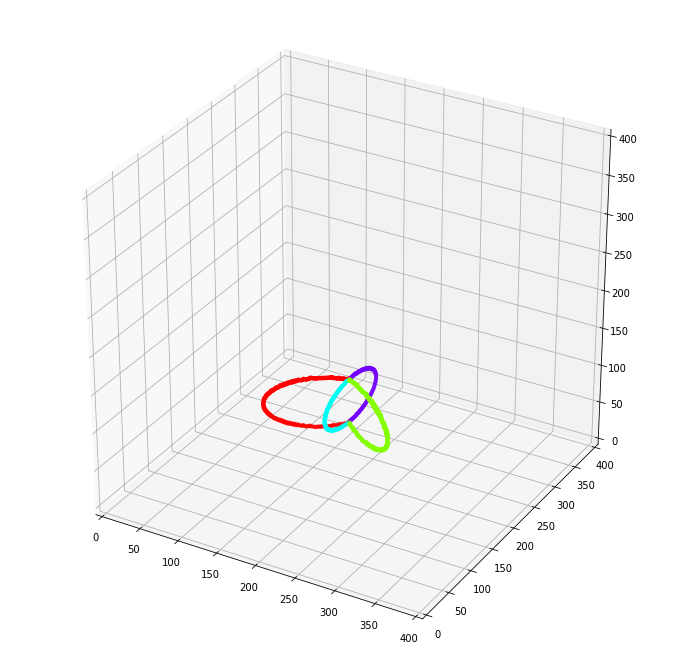

In [9]:
### Show identified TJs as 3D scatter

# Prepare the plot
fig = plt.figure(figsize=(12,12))
ax  = fig.add_subplot(111, projection='3d')

# Plot each TJ in a different color
for TJ_num,TJ_ID in enumerate(TJs.keys()):
    ax.scatter(TJs[TJ_ID][:,2], TJs[TJ_ID][:,1], TJs[TJ_ID][:,0],
               c=[TJ_num for _ in range(TJs[TJ_ID].shape[0])], 
               cmap='hsv', vmin=0, vmax=len(TJs), s=10)

## Also show cell outlines [takes several seconds to render!]
#ax.scatter([c[2] for c in OCs],
#           [c[1] for c in OCs],
#           [c[0] for c in OCs],
#           c='gray', alpha=0.05, linewidth=0, s=5)

# Axis limits
ax.set_xlim([0,400])
ax.set_ylim([0,400])
ax.set_zlim([0,400])  # NOTE: RESULT IS SQUASHED IF RESOLUTION IS NOT CONSIDERED!

# Finish
plt.show()

### Spline Fitting

*Turns out spline fitting requires the input points to be roughly in order along the spline, which isn't guaranteed in our case. Ordering the points happens to be far harder problem than one might imagine (it's a variation of traveling salesman) but luckily it can be solved quite well with a Breadth-First Search (BFS). This solution is partially inspired by Imanol Luengo's answer to [this SO question](https://stackoverflow.com/questions/37742358/sorting-points-to-form-a-continuous-line).*

In [10]:
### Get an example TJ

TJ = TJs[list(TJs.keys())[0]]

In [11]:
### Get all pairwise distances

import scipy.spatial.distance as ds
dists = ds.squareform(ds.pdist(TJ))

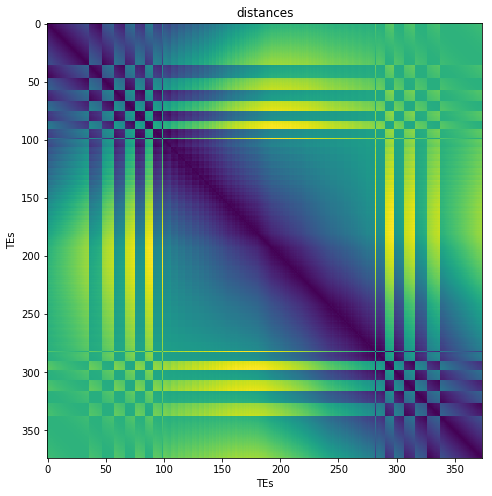

In [12]:
### Plot distance matrix

plt.figure(figsize=(8,8))
plt.imshow(dists)
plt.title("distances")
plt.xlabel('TEs')
plt.ylabel('TEs')
plt.show()

In [13]:
### Generate graph based on N nearest neighbors

# Get nearest neighbors
from sklearn.neighbors import NearestNeighbors  # TODO: Replace with scipy kdTRee
N_neighbors = 10  # Note: the outcome seems quite robust to this number; still think about how to set this?
NN_graph = NearestNeighbors(10).fit(dists).kneighbors_graph()

# Create the graph
import networkx as nx
G = nx.from_scipy_sparse_matrix(NN_graph)
nx.is_connected(G)  # TODO: Use this as a sanity check!

True

In [14]:
### Find BFS tree from all sources

all_paths = []
all_dsums = []
for n in G.nodes():
    
    # Get BFS tree
    path = list(nx.bfs_tree(G, n))
    
    # Get sum of all distances within tree
    dsum = 0.0
    for p in range(len(path)-1):
        dsum += dists[path[p], path[p+1]]
    
    # Keep results
    all_paths.append(path)
    all_dsums.append(dsum)

# Select the best solution
best_path = all_paths[np.argmin(all_dsums)]
sorted_TJ = TJ[best_path]

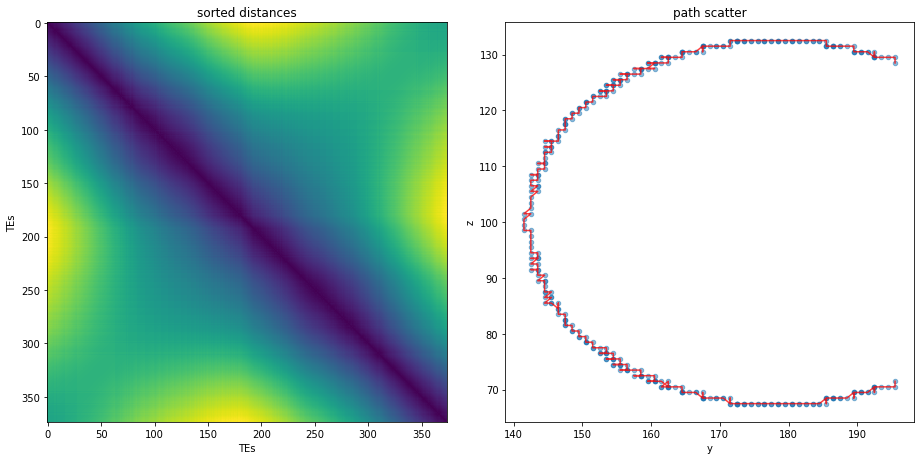

In [15]:
### Visualize the sorted result

# Get sorted pairwise distances
sorted_dists = ds.squareform(ds.pdist(sorted_TJ))

# Plot pairwise distances
fig, ax = plt.subplots(1, 2, figsize=(13,6.5))
ax[0].imshow(sorted_dists)
ax[0].set_title("sorted distances")
ax[0].set_xlabel('TEs'); ax[0].set_ylabel('TEs')

# Plot path/tree on scatter
ax[1].scatter(TJ[:,1], TJ[:,0], s=20, alpha=0.5)
ax[1].plot(sorted_TJ[:,1], sorted_TJ[:,0], c='r', alpha=0.75)
ax[1].set_title("path scatter")
ax[1].set_xlabel('y'); ax[1].set_ylabel('z')

# Done
plt.tight_layout()
plt.show()

In [16]:
def sortPoints(TJ):
    #euclidian distances
    dists = ds.squareform(ds.pdist(TJ))
    
    #sciKit Learn
    N_neighbors = 10  # Note: the outcome seems quite robust to this number; still think about how to set this?
    NN_graph = NearestNeighbors(10).fit(dists).kneighbors_graph()
    
    #networkx : implement the "nx.is_connected(G)" method to check if everything is connencted
    G = nx.from_scipy_sparse_matrix(NN_graph)
    
    all_paths = []
    all_dsums = []
    for n in G.nodes():

        # Get BFS tree
        path = list(nx.bfs_tree(G, n))

        # Get sum of all distances within tree
        dsum = 0.0
        for p in range(len(path)-1):
            dsum += dists[path[p], path[p+1]]

        # Keep results
        all_paths.append(path)
        all_dsums.append(dsum)

    # Select the best solution
    best_path = all_paths[np.argmin(all_dsums)]
    sorted_TJ = TJ[best_path]
    return sorted_TJ

In [17]:
tckDict={}
fpDict={}
ierDict={}
msgDict={}
splevDict = {}
for TJ_ID in TJs.keys():
    
    #sorts all of the points for each TJ
    TJs[TJ_ID] = sortPoints(TJs[TJ_ID])
    
    #tck has 2 values: tck[0] is tck and tck[1] is u
    #gets the knots for the spline
    tck, fp, ier, msg = scipolate.splprep(x = [TJs[TJ_ID][:,0],TJs[TJ_ID][:,1],
                                            TJs[TJ_ID][:,2]], k = 3, full_output=1)
    #could adjust s to fit the spline more smoothly to the curve
    
    tckDict[TJ_ID] = tck
    fpDict[TJ_ID] = fp
    ierDict[TJ_ID] = ier
    msgDict[TJ_ID] = msg
    
    #evaluates the knots produced and puts them in xyz positions
    splevDict[TJ_ID] = scipolate.splev(x = np.linspace(0.0,1.0,100), tck = tckDict[TJ_ID][0])

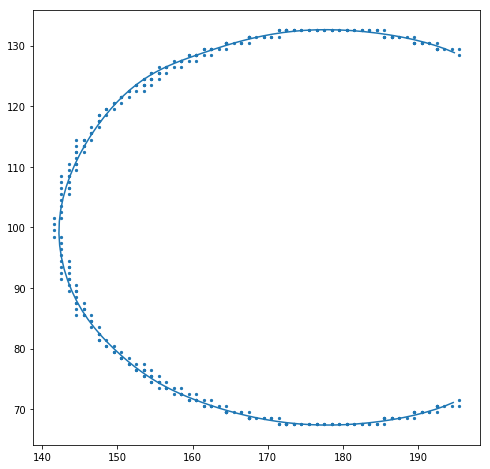

In [18]:
plt.figure(figsize = (8,8))
plt.scatter(TJs[(0, 1, 2)][:,1], 
            TJs[(0, 1, 2)][:,0],
            s=5)
plt.plot(splevDict[(0, 1, 2)][1],
            splevDict[(0, 1, 2)][0])
plt.show()

In [19]:
TJs.keys()

dict_keys([(0, 1, 2), (0, 1, 3), (1, 2, 3), (0, 2, 3)])

/Users/vivek/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


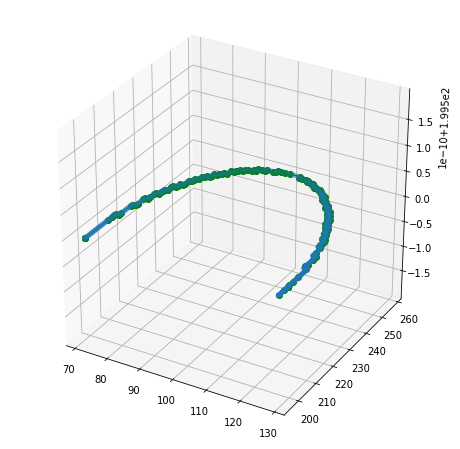

In [20]:
TJ = (0, 2, 3)
tck, u = scipolate.splprep([TJs[TJ][:,0],TJs[TJ][:,1],
                                            TJs[TJ][:,2]], s=2)
x_knots, y_knots, z_knots = scipolate.splev(tck[0], tck)
u_fine = np.linspace(0,1,200)
x_fine, y_fine, z_fine = scipolate.splev(u_fine, tck)

fig2 = plt.figure(figsize = (8,8))
ax3d = fig2.add_subplot(111, projection='3d')
#ax3d.plot(x_true, y_true, z_true, 'b')
#ax3d.plot(x_sample, y_sample, z_sample, 'r*')
ax3d.plot(x_knots, y_knots, z_knots, 'go')
ax3d.plot(x_fine, y_fine, z_fine, 'g')
ax3d.scatter(TJs[TJ][:,0], TJs[TJ][:,1], TJs[TJ][:,2])

fig2.show()
plt.show()

In [24]:
import sympy.geometry.plane as sp
tVals=np.linspace(0,1,len(TJs[(0,1,2)]))
points=scipolate.splev(tVals,tck=tckDict[(0,1,2)][0])
points=np.transpose(points)
tVals2=[]
for i in tVals:
    tVals2.append(i+0.000001)
v=scipolate.splev(tVals2,tck=tckDict[(0,1,2)][0])
v=np.transpose(v)
vectors=np.asarray(v)-np.asarray(points)
planes=[]
for i in range(0,len(vectors)):
    planes.append(sp.Plane(points[i],normal_vector=vectors[i]))




In [25]:
OCs.max(axis=0)

array([141, 271, 311])

In [168]:
from scipy import spatial
import sympy.geometry.line as ln

tree=spatial.KDTree(OCs)
NN=tree.query_ball_point(points[50], 10)
sublist=OCs[NN]
uvArr=np.empty((len(NN),3))
for idx,coords in enumerate(sublist):
    uvArr[idx,:] = sp.Plane.projection(planes[50], coords)
    if idx % 50 == 0: print(idx)



    
    
    


0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950


In [28]:
uvArr[0]

array([120.17636686, 190.68501074, 198.60133135])

In [65]:
import sympy.geometry as sp
import math
import numpy as np
from sympy.abc import x,y,z, u,v,e,  r,p,q
def findX(plane_point,arbpt,projection_p):
    p=plane_point.distance(projection_p)
    r=plane_point.distance(arbpt)
    q=projection_p.distance(arbpt)
    if(r==p+q):
        x_out = line_proj.distance(plane_point)
    elif(p > q):
        x_out = line_proj.distance(plane_point)
    else:
        x_out= 0- line_proj.distance(plane_point)
        
    return x_out
plane_point  = sp.Point3D(x,y,z)
plane_vector = sp.Point3D(u,v,e)
projection_p = sp.Point3D(r,p,q)

plane = sp.Plane(plane_point, normal_vector=plane_vector)
projected = plane.projection(projection_p)

arbpt = plane.projection(sp.Point3D(x+u,y+2*v,z+3*e))
arbline = sp.Line3D(plane_point, arbpt)
line_proj = arbline.projection(projected)
x_out=findX(plane_point,arbpt,projection_p)

arbpt2=plane.projection(sp.Point3D())    
y_out = line_proj.distance(projected)


    
print('wat')
import numpy as np
distance=projected.distance(projection_p)

print(y_out, x_out,distance)


#arb   =planes[0].arbitrary_point()
#print(arb)
#ptToArb=ln.Line3D(points[0],arb)
#print(ptToArb)
#y=ptToArb.distance(sp.Point3D(uvArr[0]))
#print(y)
#a=ptToArb.projection(uvArr[0])
#x=a.distance(points[0])

#print(a)
#print(type(a))
#p1 = np.array(uvArr[0])
#p2 = np.array(points[0])
#
#squared_dist = np.sum((p1-p2)**2, axis=0)
#x = np.sqrt(squared_dist)
#planeCoords=[y,x]




wat
wat
wat


TypeError: cannot determine truth value of Relational

In [82]:
from sympy.vector import CoordSys3D,Vector
from sympy.abc import x,y,z, u,v,e,  r,p,q
from sympy import sqrt
N=CoordSys3D('N')
v1=u*N.i+v*N.j+e*N.k
crossProduct=v1.cross(N.k)
v1.dot(N.k)
sqrt((v1.magnitude()**2)*(N.k.magnitude()**2))+v1.dot(N.k)
N.orient_new_quaternion()

TypeError: orient_new_quaternion() missing 5 required positional arguments: 'name', 'q0', 'q1', 'q2', and 'q3'

In [86]:
Matrix(plane_point)

Matrix([
[x],
[y],
[z]])

In [144]:
import sympy.geometry as sp
import math
import numpy as np
from sympy.abc import u,v,e,  r,p,q

plane_point  = sp.Point3D(0,0,0)
plane_vector = sp.Point3D(u,v,e)
projection_p = sp.Point3D(r,p,q)

plane = sp.Plane(plane_point, normal_vector=plane_vector)

from sympy.matrices import Matrix, GramSchmidt
orthonormals = GramSchmidt([Matrix(plane_vector), 
                            Matrix([u,2*v,3*e]), 
                            Matrix([2*u,3*v,e])], orthonormal=True)

px = orthonormals[1].dot(Matrix(projection_p))
py = orthonormals[2].dot(Matrix(projection_p))
pz = orthonormals[0].dot(Matrix(projection_p))
dist = plane.distance(projection_p)


#arbline = sp.Line3D(plane_point, arbpt)
#line_proj = arbline.projection(projected)
#x_out=findX(plane_point,arbpt,projection_p)
#
#arbpt2=plane.projection(sp.Point3D())    
#y_out = line_proj.distance(projected)





In [130]:
from sympy import simplify

In [132]:
simplify(orthonormals[2].dot(Matrix(plane_vector)))

KeyboardInterrupt: 

In [51]:
import numpy as np

In [145]:
import sympy.utilities as ut
x_out_lambda = ut.lambdify((u,v,e,  r,p,q), px, modules='numpy')
y_out_lambda = ut.lambdify((u,v,e,  r,p,q), py, modules='numpy')
dist_lambda  = ut.lambdify((u,v,e,  r,p,q), pz, modules='numpy')

In [53]:
test = np.arange(100)[np.newaxis,:]

In [54]:
test.shape

(1, 100)

In [55]:
out = x_out_lambda(np.arange(1,100)[np.newaxis,:].T,np.arange(1,100)[np.newaxis,:].T,np.arange(1,100)[np.newaxis,:].T, 
             np.arange(1,100)[np.newaxis,:].T,np.arange(1,100)[np.newaxis,:].T,np.arange(1,100)[np.newaxis,:].T, 
             np.arange(5000),np.arange(5000),np.arange(5000))

In [56]:
out2 = y_out_lambda(np.arange(1,100)[np.newaxis,:].T,np.arange(1,100)[np.newaxis,:].T,np.arange(1,100)[np.newaxis,:].T, 
             np.arange(1,100)[np.newaxis,:].T,np.arange(1,100)[np.newaxis,:].T,np.arange(1,100)[np.newaxis,:].T, 
             np.arange(5000),np.arange(5000),np.arange(5000))

In [137]:
uvArr.shape

(1153, 3)

In [152]:
uvArr

array([[120.17636686, 190.68501074, 198.60133135],
       [120.41944192, 190.25088139, 199.05187209],
       [125.98189435, 192.39030311, 199.82227987],
       ...,
       [133.47452917, 194.58051843, 201.4064481 ],
       [133.66658348, 195.23751156, 200.97231875],
       [134.41801604, 193.68145024, 202.53419326]])

In [138]:
uvArr_rdy = uvArr - points[0]

In [169]:
uvArr_rdy = uvArr - points[50]

xCoords=x_out_lambda(vectors[0][2],vectors[0][1],vectors[0][0],uvArr_rdy[:,2],uvArr_rdy[:,1],uvArr_rdy[:,0])
yCoords=y_out_lambda(vectors[0][2],vectors[0][1],vectors[0][0],uvArr_rdy[:,2],uvArr_rdy[:,1],uvArr_rdy[:,0])
distance=dist_lambda(vectors[0][2],vectors[0][1],vectors[0][0],uvArr_rdy[:,2],uvArr_rdy[:,1],uvArr_rdy[:,0])

In [170]:
print(x_out_lambda(vectors[0][2],vectors[0][1],vectors[0][0],vectors[0][2],vectors[0][1],vectors[0][0]))
print(y_out_lambda(vectors[0][2],vectors[0][1],vectors[0][0],vectors[0][2],vectors[0][1],vectors[0][0]))
print(dist_lambda(vectors[0][2],vectors[0][1],vectors[0][0],vectors[0][2],vectors[0][1],vectors[0][0]))

-4.0657581468206416e-20
6.776263578034403e-21
0.00019365624194102942


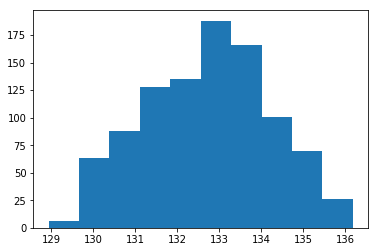

In [171]:
plt.hist(uvArr[:,0])
plt.show()

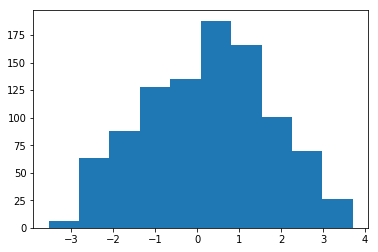

In [172]:
plt.hist(uvArr_rdy[:,0])
plt.show()

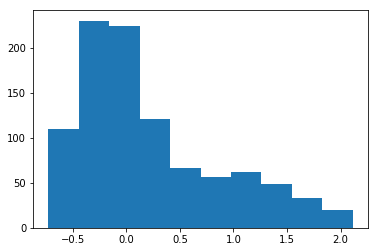

In [173]:
plt.hist(distance)
plt.show()

In [174]:
distance

array([-2.10032917e-01, -1.79565409e-01, -1.49097900e-01, -1.18630391e-01,
       -8.81628826e-02,  1.65577435e-01,  1.29240849e+00,  1.96044944e-01,
        1.32287600e+00,  1.35334351e+00,  1.69848635e+00,  1.72895386e+00,
        1.38381102e+00,  1.75942137e+00, -5.46065956e-01, -5.41451452e-01,
       -1.65841099e-01, -2.33638271e-01, -8.11781225e-03, -4.96488394e-01,
       -4.66020885e-01, -5.48313606e-01, -1.20878042e-01, -9.04105331e-02,
       -2.03170763e-01, -1.72703254e-01,  1.41972081e-01,  5.17582433e-01,
        2.54732310e-01,  1.72439590e-01,  2.02907098e-01,  7.43102892e-01,
        6.30342663e-01,  6.60810172e-01,  5.48049942e-01,  5.78517451e-01,
       -3.46398501e-01, -3.15930992e-01, -4.28691222e-01, -3.98223713e-01,
       -5.10983943e-01, -4.80516434e-01, -2.85463484e-01, -2.54995975e-01,
       -3.67756204e-01, -3.37288696e-01, -4.50048925e-01, -4.19581417e-01,
        2.92118513e-02,  5.96793600e-02, -5.30808696e-02, -2.26133609e-02,
       -1.35373590e-01, -

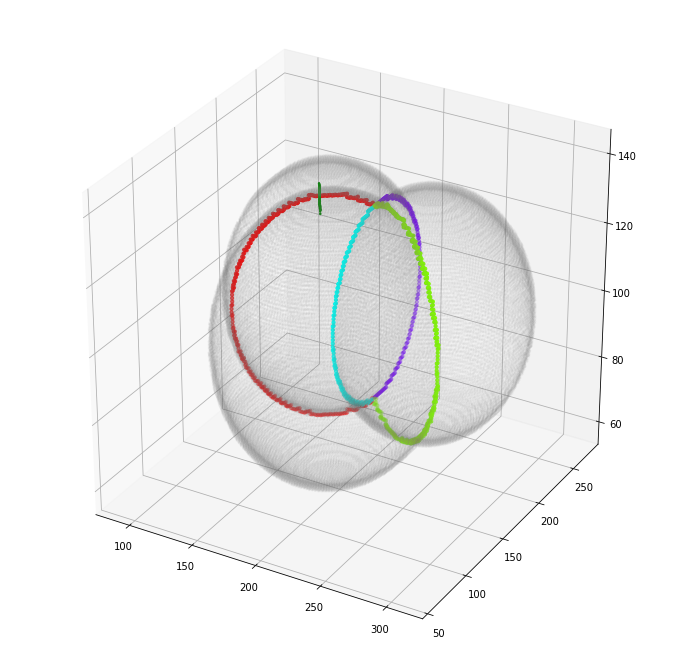

In [187]:
# Prepare the plot
fig = plt.figure(figsize=(12,12))
ax  = fig.add_subplot(111, projection='3d')

# Plot each TJ in a different color
for TJ_num,TJ_ID in enumerate(TJs.keys()):
    ax.scatter(TJs[TJ_ID][:,2], TJs[TJ_ID][:,1], TJs[TJ_ID][:,0],
               c=[TJ_num for _ in range(TJs[TJ_ID].shape[0])], 
               cmap='hsv', vmin=0, vmax=len(TJs), s=10)

# Also show cell outlines [takes several seconds to render!]
ax.scatter([c[2] for c in OCs[::2]],
           [c[1] for c in OCs[::2]],
           [c[0] for c in OCs[::2]],
           c='gray', alpha=0.05, linewidth=0, s=5)

ax.scatter([c[2] for c in uvArr],
           [c[1] for c in uvArr],
           [c[0] for c in uvArr],
           c='green', alpha=0.5, linewidth=0, s=5)

## Axis limits
#ax.set_xlim([0,400])
#ax.set_ylim([0,400])
#ax.set_zlim([0,200])  # NOTE: RESULT IS SQUASHED IF RESOLUTION IS NOT CONSIDERED!

# Finish
plt.show()

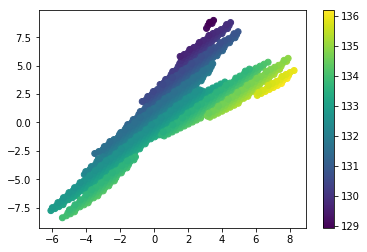

In [178]:
plt.scatter(xCoords[distance<np.percentile(distance,100)], 
            yCoords[distance<np.percentile(distance,100)], 
            c=uvArr[distance<np.percentile(distance,100),0],)
            #vmin=np.min(distance), vmax=np.max(distance))
plt.colorbar()
plt.show()

In [14]:
import matplotlib.pyplot as plt

In [19]:
np.sum(np.isnan(out))

0

In [29]:
out.shape

(99, 5000)

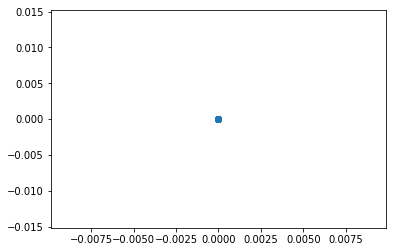

In [28]:
plt.scatter(out[50,:], out2[50,:], c=)
plt.show()

In [28]:
y_out_lambda(100,100,100, 1,1,1, 52,55,90)

13.063945294843617

In [116]:
from sympy import sin as spsin
#from sympy.abc import x, y
f = ut.lambdify((x,y), spsin(x+y), modules='numpy')

In [115]:
f(3.14)

AttributeError: 'Add' object has no attribute 'sin'

In [90]:
print(x_out)

sqrt((-x + (x*(u**2 + v**2)**2*(e**2 + u**2 + v**2)**2 - (e*u*sqrt(u**2 + v**2)*sin(t) + v*sqrt(e**2*u**2 + e**2*v**2 + (u**2 + v**2)**2)*cos(t))*(-(u**2 + v**2)**(3/2)*(e*(e*q - e*z + p*v + r*u - u*x - v*y) - (q - z)*(e**2 + u**2 + v**2))*sin(t) + (u*(e*q - e*z + p*v + r*u - u*x - v*y) - (r - x)*(e**2 + u**2 + v**2))*(e*u*sqrt(u**2 + v**2)*sin(t) + v*sqrt(e**2*u**2 + e**2*v**2 + (u**2 + v**2)**2)*cos(t)) + (v*(e*q - e*z + p*v + r*u - u*x - v*y) - (p - y)*(e**2 + u**2 + v**2))*(e*v*sqrt(u**2 + v**2)*sin(t) - u*sqrt(e**2*u**2 + e**2*v**2 + (u**2 + v**2)**2)*cos(t))))/((u**2 + v**2)**2*(e**2 + u**2 + v**2)**2))**2 + (-y + (y*(u**2 + v**2)**2*(e**2 + u**2 + v**2)**2 - (e*v*sqrt(u**2 + v**2)*sin(t) - u*sqrt(e**2*u**2 + e**2*v**2 + (u**2 + v**2)**2)*cos(t))*(-(u**2 + v**2)**(3/2)*(e*(e*q - e*z + p*v + r*u - u*x - v*y) - (q - z)*(e**2 + u**2 + v**2))*sin(t) + (u*(e*q - e*z + p*v + r*u - u*x - v*y) - (r - x)*(e**2 + u**2 + v**2))*(e*u*sqrt(u**2 + v**2)*sin(t) + v*sqrt(e**2*u**2 + e**2*v**2 + 

### TODO

- Brodland approach
    - Fit splines to outlines in the image plane
    - Identify angles in image plane for each TE *[sort of needed in both]*
    - Fit splines to TJs *[needed in both]*
    - Find normal plane to TJ-spline at each TE *[needed in both]*
    - Project image plane angles onto normal plane
    
    
- Better approach?
    - Fit splines to TJs *[needed in both]*
    - Find normal plane to TJ-spline at each TE *[needed in both]*
    - Identify angles in normal plane for each TE *[sort of needed in both]*